## ***00.*** - Install & Import Dependencies

In [0]:
# Reset all runtimes then install:
#!pip install tensorflow-gpu

# Reset all runtimes again, 
# Change Runtime Hardware Accelerator to: GPU
# Then comment this out.

In [1]:
# installing tensorboard in colab
!pip install -U tensorboardcolab

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


In [2]:
!pip install livelossplot

In [0]:
from __future__ import print_function

import numpy as np
import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint

from tensorboardcolab import *
from keras.callbacks import TensorBoard

from livelossplot.keras import PlotLossesCallback

In [6]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://117ad6e2.ngrok.io


## ***01.*** - Import the Data and Exploring the Data

In [0]:
num_classes = 10

img_width, img_height  = 28, 28

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_width, img_height )
    x_test = x_test.reshape(x_test.shape[0], 1, img_width, img_height )
    input_shape = (1, img_width, img_height )
else:
    x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 1)
    x_test = x_test.reshape(x_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalizing the data
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## ***02.*** - Data Augmentation

In [0]:
# What transformation are we going to do to the image?
train_gen = ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.08, 
                               shear_range=0.3, 
                               height_shift_range=0.08, 
                               zoom_range=0.08)
test_gen = ImageDataGenerator()

# Applying the transformation to the training and testing set
training_set= train_gen.flow(x_train, y_train, batch_size=64)
test_set= train_gen.flow(x_test, y_test, batch_size=64)

## ***03.*** - Model Network

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

## ***04.*** - Hyperparameters
*Most fine-tuning will happened in this block* 

In [12]:
# hyperparameters
learning_rate = 0.001

num_epochs = 10
verbosity = 1

steps_per_epoch = int(x_train.shape[0] / 64)
validation_steps = int(x_test.shape[0] / 64)
#or
batch_size = 128


# output files
TRAINING_LOGS_FILE = 'training_logs_{}.csv'.format(str(learning_rate))
MODEL_FILE='main.h5'


# double checking
'''
print(x_train.shape[0])
print(steps_per_epoch)

print(x_test.shape[0])
print(validation_steps)
'''

'\nprint(X_train.shape[0])\nprint(steps_per_epoch)\n\nprint(X_test.shape[0])\nprint(validation_steps)\n'

## ***06.*** - Model Compiling (Optimizer, Loss, Metrics)

In [13]:
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=0, 
                              mode='auto',
                              epsilon=0.00001,
                              cooldown=4, 
                              min_lr=10e-7)

# Streams the results into a CSV File
# Can be useful on comparing different learning rates
csv_logger = CSVLogger(filename=TRAINING_LOGS_FILE, 
                       separator=',', append=False)

# Saves the Model after every epoch
model_checkpoint = ModelCheckpoint(filepath=MODEL_FILE,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='max',
                                   period=5)

plot_losses = PlotLossesCallback()
tboard = TensorBoardColabCallback(tbc)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
# listing all the callbacks
callbacks = [plot_losses, tboard, csv_logger, model_checkpoint]

## ***06.*** - Model Compiling (Optimizer, Loss, Metrics)

In [0]:
from keras import optimizers

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])

## ***07.*** - Model Fitting and Evaluating

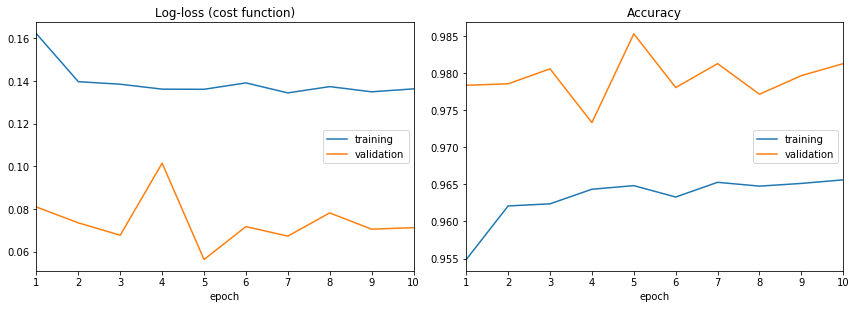

Log-loss (cost function):
training   (min:    0.134, max:    0.162, cur:    0.136)
validation (min:    0.056, max:    0.101, cur:    0.071)

Accuracy:
training   (min:    0.955, max:    0.966, cur:    0.966)
validation (min:    0.973, max:    0.985, cur:    0.981)


In [24]:
'''model.fit(x_train, y_train,
          batch_size=batch_size,
          #steps_per_epoch=steps_per_epoch,
          #validation_steps=validation_steps,
          epochs=num_epochs,
          verbose=verbosity,
          validation_data=(x_test, y_test),
          callbacks=callbacks)'''

model.fit_generator(training_set,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=num_epochs,
                    verbose=verbosity,
                    validation_data=test_set,
                    callbacks=callbacks)

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06440116626743989
Test accuracy: 0.9868
